In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), ".."), ".."))
sys.path.append(parent_dir)


In [14]:
from data_generation.simulations.grid import Grid, fractional_transformation, logistic_transformation, tangent_transformation
from data_generation.visualization.create_plots import plot_2D_vector_field, create_2D_vectorfield, plot_2D_vector_field_over_grid
from data_generation.models.tech_substitution import TechnologySubstitution
from data_generation.models.tech_substitution import NumericalSolver as TechNumericalSolver
from data_generation.models.general_ode_solver import FitzHughNagumoModel
from data_generation.models.general_ode_solver import NumericalSolver as GenNumericalSolver

In [15]:
def zero_vectorfield(X, Y):
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    return U, V


In [16]:
def test_vectorfield(X, Y):
    U = Y
    V = -X
    return U, V

In [17]:
myinfbounds = [(0, np.inf), (0, np.inf)]
myresolution = [10, 10]
myeasybounds = [(0,100), (0, 100)]
myeasyresolution = [10, 10]

trafos = [fractional_transformation(3.0), fractional_transformation(3.0)]
infgrid = Grid(myinfbounds, myresolution, trafos)
easygrid = Grid(myeasybounds, myeasyresolution)
    

### Example Plotting Usage

#### Direct Vectorfield Plotting

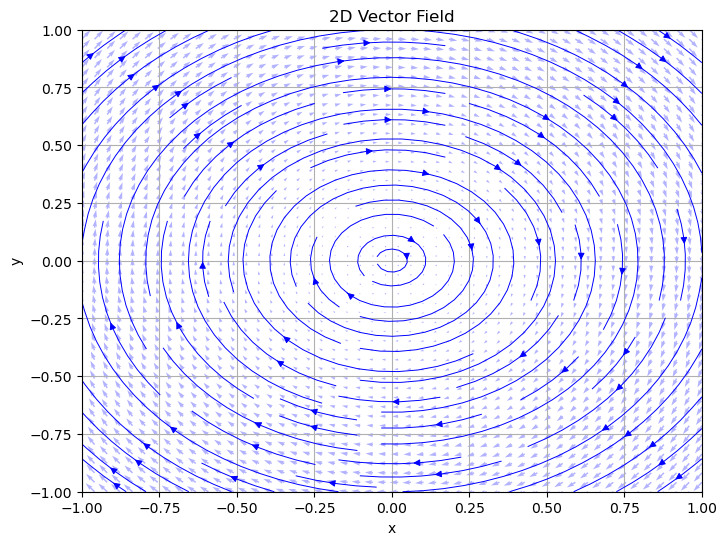

In [18]:
plot_2D_vector_field(test_vectorfield, [[-1, 1], [-1, 1]])

#### Vectorfield from Model over Grid

#### FHN-Model - General ODE Solver

In [19]:
fmodel = FitzHughNagumoModel(control_params=['b','I'])
fsolver = GenNumericalSolver(fmodel)

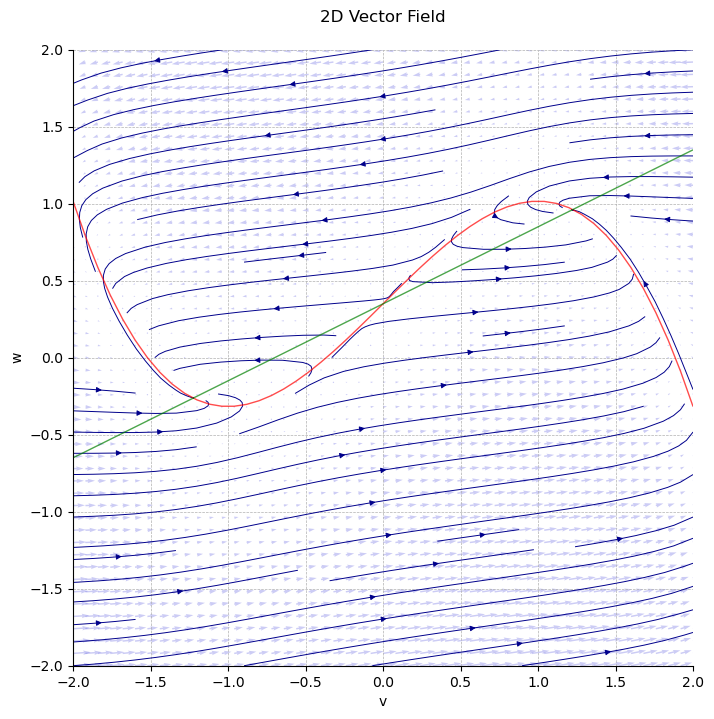

In [20]:
fhnbounds = [(-2,2),(-2,2)]
fhnres = [1000,1000]
fhngrid = Grid(fhnbounds, fhnres)
plot_2D_vector_field_over_grid(fhngrid, fsolver, control = [2.0, 0.35], axis_names=['v','w'], display_nullclines=True)

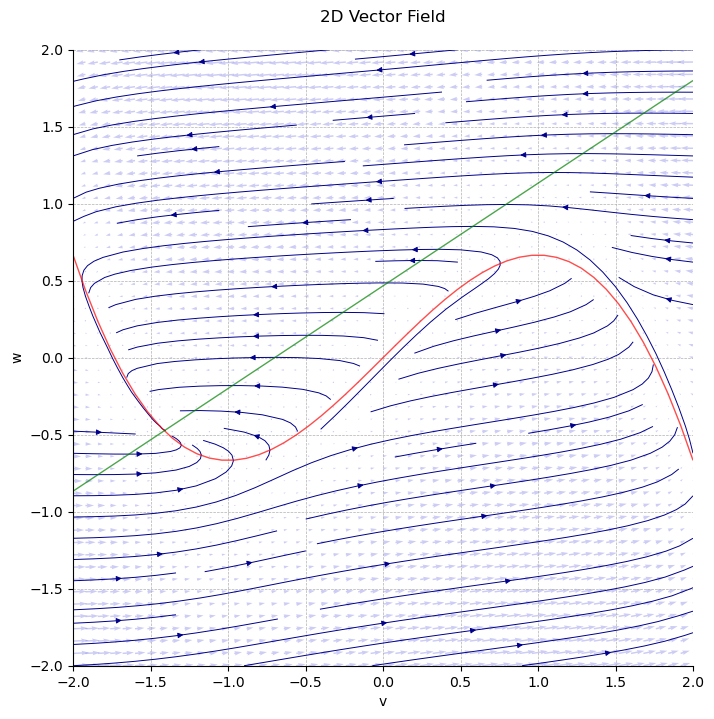

In [21]:
fhnbounds = [(-2,2),(-2,2)]
fhnres = [100,100]
fhngrid = Grid(fhnbounds, fhnres)
plot_2D_vector_field_over_grid(fhngrid, fsolver, control = [1.5, 0.0], axis_names=['v','w'], display_nullclines=True)

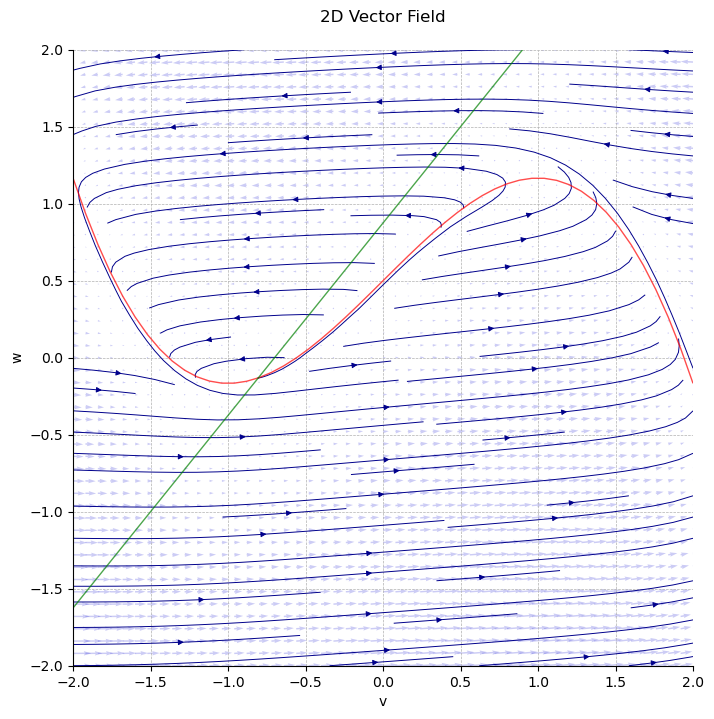

In [22]:
fhnbounds = [(-2,2),(-2,2)]
fhnres = [100,100]
fhngrid = Grid(fhnbounds, fhnres)
plot_2D_vector_field_over_grid(fhngrid, fsolver, control = [0.8, 0.5], axis_names=['v','w'], display_nullclines=True)

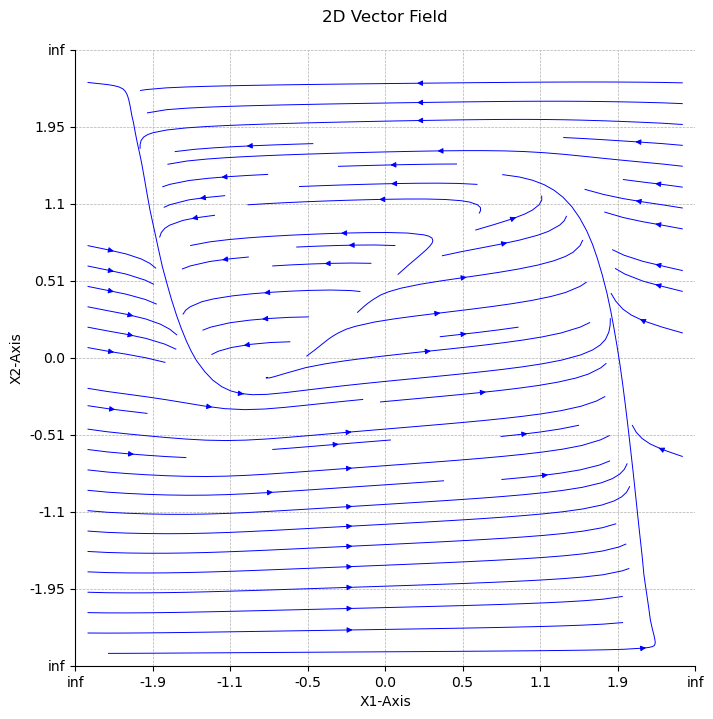

In [30]:
# Experiment with 3 actions 
    # 1) b=2, I = 0.35 ---- two basins of attraction
    # 2) b=0.8, I=0.5  ---- limit cycle
    # 3) b=1.5, I=0.0  ---- single stable fix point, if far away 
fmodel = FitzHughNagumoModel(control_params=['I','b'])
fsolver = GenNumericalSolver(fmodel)
fhnres = [10,10]
log_trafos = [logistic_transformation({'k': 1, 'x_0': 0}), logistic_transformation({'k': 1, 'x_0': 0})]
fhninfgrid = Grid([(-np.inf,np.inf),(-np.inf,np.inf)], fhnres, log_trafos)

fig, axes = plt.subplots(figsize=(8, 8))
#plot_2D_vector_field_over_grid(fhninfgrid, fsolver, control = [0.35, 2], ax= axes, display_vectorfield=False, streamplot_colour='green')
plot_2D_vector_field_over_grid(fhninfgrid, fsolver, control = [0.5, 0.8], ax= axes, display_vectorfield=False, streamplot_colour='blue')
#plot_2D_vector_field_over_grid(fhninfgrid, fsolver, control = [0, 1.5], ax= axes, display_vectorfield=False, streamplot_colour='red')

#### Technology Substitution

In [24]:
model = TechnologySubstitution(D0=1.0, delta=1.0, sigma=0.2, alpha=0.5, gamma1=1.0)
solver = TechNumericalSolver(model)

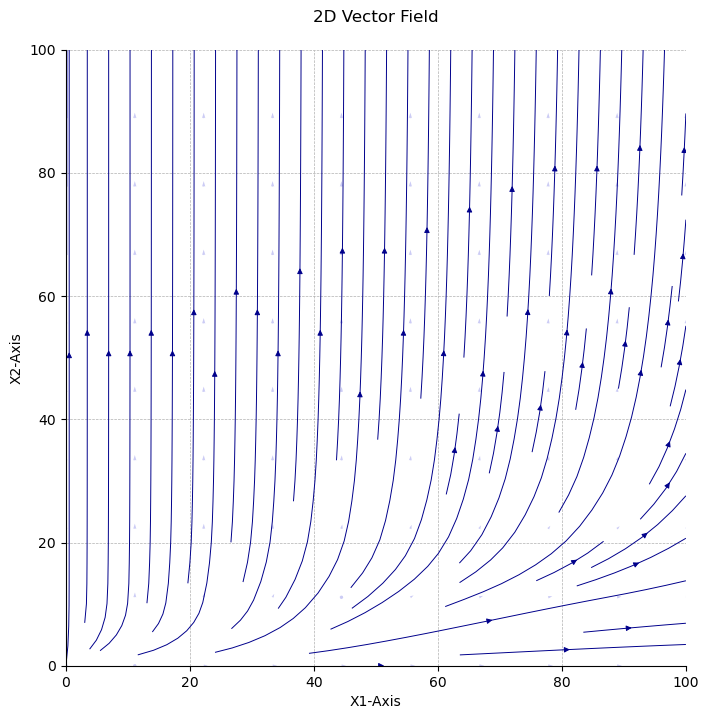

In [25]:
plot_2D_vector_field_over_grid(easygrid, solver, control=0.5, display_vectorfield=True, resolution = 10)


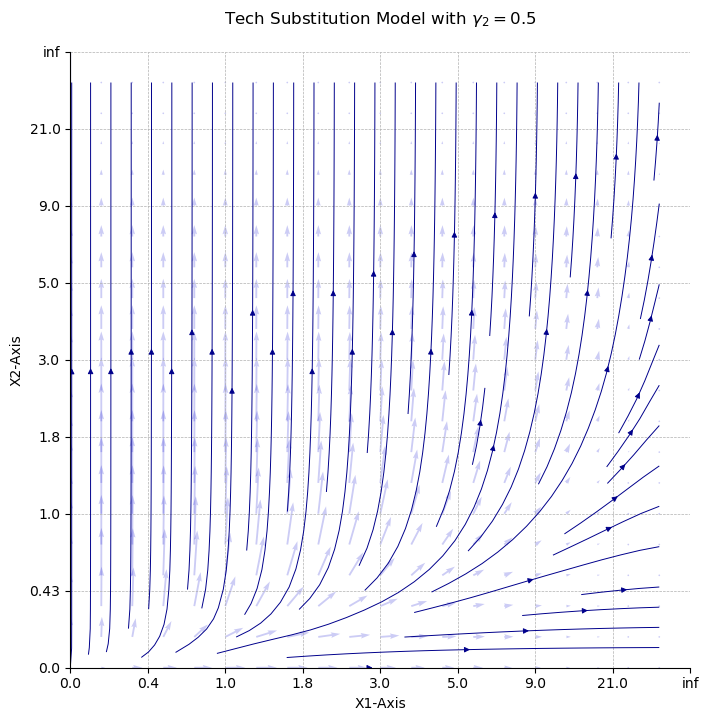

In [26]:
title = r"Tech Substitution Model with $\gamma_{2} = 0.5$"
save_to_path = "./figures/tech_sub_05.png"
plot_2D_vector_field_over_grid(infgrid, solver, 0.5, display_vectorfield=True, resolution=21, title= title, display_grid=True, display_vectorfield_magnitude=False)



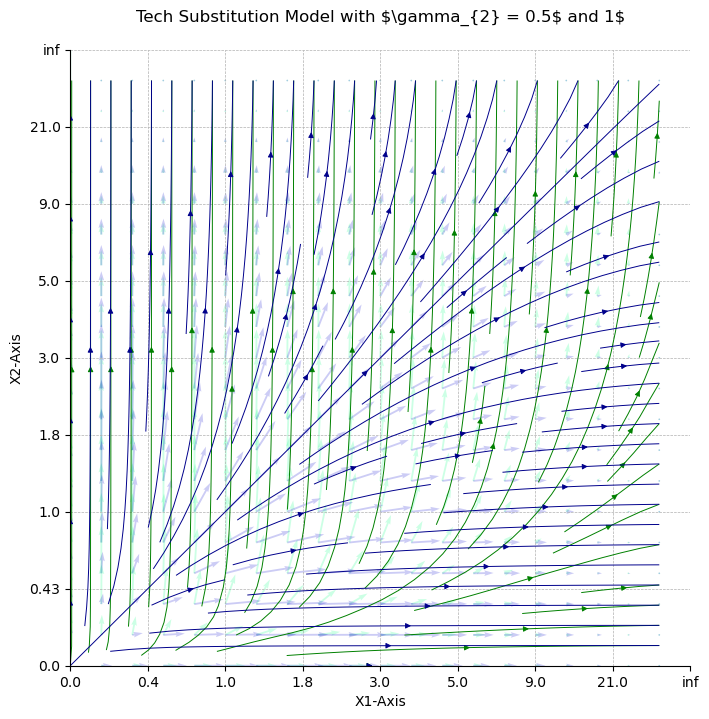

In [27]:
fig, axes = plt.subplots(figsize=(8, 8))

title = r"Tech Substitution Model with $\gamma_{2} = 0.5$ and 1$"
save_to_path = "./figures/tech_sub_mult.png"
plot_2D_vector_field_over_grid(infgrid, solver, 0.5, display_vectorfield=True, resolution=21, title= title, ax= axes, streamplot_colour='green', vectorfield_colour='springgreen')
plot_2D_vector_field_over_grid(infgrid, solver, 1, display_vectorfield=True, resolution=21, title= title, ax= axes)


plt.show()


#### Technology Substitution2

In [28]:
tangent_grid = Grid([(0, np.inf), (0, np.inf)], [100, 100],[tangent_transformation(3, alpha=0.5), tangent_transformation(3, alpha=0.5)])

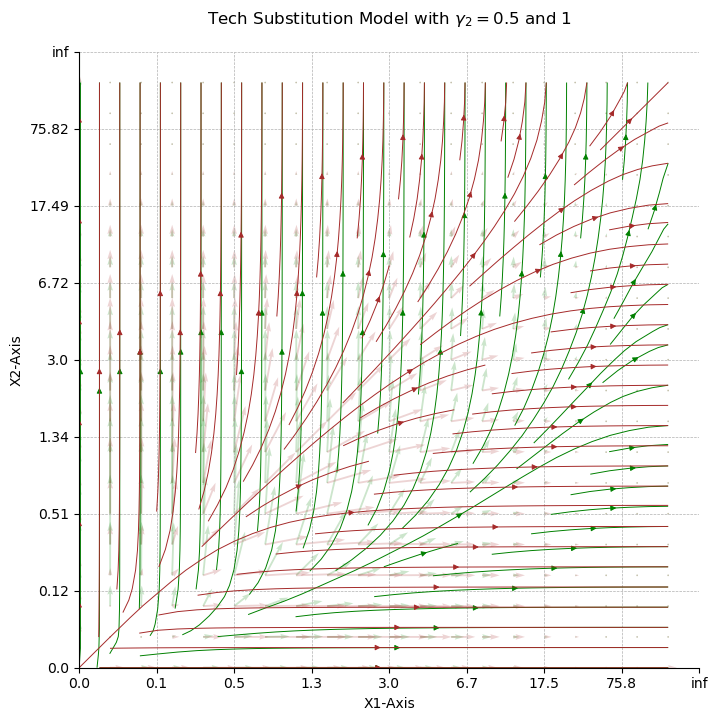

In [29]:
fig, axes = plt.subplots(figsize=(8, 8))

title = r"Tech Substitution Model with $\gamma_{2} = 0.5$ and $1$"
plot_2D_vector_field_over_grid(tangent_grid, solver, 0.5, display_vectorfield=True, resolution=21, title= title, ax= axes, streamplot_colour='green', vectorfield_colour='green')
plot_2D_vector_field_over_grid(tangent_grid, solver, 1, display_vectorfield=True, resolution=21, title= title, ax= axes, streamplot_colour='brown', vectorfield_colour='brown')


plt.show()